In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IoB power consumption/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.count()

Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [ ]:
values = df.values.astype('float32')
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
df['ds']=df.index
df["day_name"]= df['ds'].dt.day_name()
#del df.ds

In [ ]:
df.drop(['ds'], axis=1, inplace=True)

In [ ]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670,Saturday
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336,Saturday
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666,Saturday
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800003,Saturday
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.099998,Saturday


In [ ]:
droping_list_all=[]
for j in range(0,9):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
for j in range(0,8):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
day_name                 0
dtype: int64

In [ ]:
df.count()

Global_active_power      2075259
Global_reactive_power    2075259
Voltage                  2075259
Global_intensity         2075259
Sub_metering_1           2075259
Sub_metering_2           2075259
Sub_metering_3           2075259
sub_metering_4           2075259
day_name                 2075259
dtype: int64

# LSTM

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
df_resample = df.resample('h').sum() 
df_resample.shape

(34589, 8)

In [ ]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,1998.466675


In [ ]:
df_resample["day_name"]= df_resample.index.day_name()
df_resample.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398,Saturday
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951,Saturday


In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values 

# frame as supervised learning
reframed1 = series_to_supervised(df_resample, 1, 1)

# drop columns we don't want to predict
reframed2= reframed1.drop(reframed1.columns[[7,8,10,11,12,16,17]], axis=1)
reframed2.head()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed2.values)
reframed = pd.DataFrame(scaled, columns= ["var1(t-1)","var2(t-1)","var3(t-1)","var4(t-1)","var5(t-1)"	,"var6(t-1)","var7(t-1)","var1(t)",	"var5(t)","var6(t)","var7(t)"])
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var5(t),var6(t),var7(t)
0,0.374384,0.163471,0.000000,0.371473,0.0,0.006820,0.469451,0.550442,0.0,0.144652,0.782676
1,0.545045,0.088127,0.844110,0.541487,0.0,0.144652,0.782676,0.514830,0.0,0.030869,0.774169
2,0.509006,0.094957,0.831981,0.502152,0.0,0.030869,0.774169,0.494617,0.0,0.000000,0.778809
3,0.488550,0.081648,0.839532,0.481110,0.0,0.000000,0.778809,0.462055,0.0,0.008973,0.798917
4,0.455597,0.083705,0.867315,0.449904,0.0,0.008973,0.798917,0.330590,0.0,0.002872,0.205723


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 365*3*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]


# split into input and outputs
train_X, train_y = train[:, :-4], train[:, -4:]
test_X, test_y = test[:, :-4], test[:, -4:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 


(26280, 1, 7) (26280, 1, 4) (8308, 1, 7) (8308, 1, 4)


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout


# E1D1
n_features =4
#
encoder_inputs = tf.keras.layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(1)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)

decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 100), (None, 43200       input_2[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 100)       0           lstm_2[0][0]                     
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 1, 100)       80400       repeat_vector_1[0][0]            
                                                                 lstm_2[0][1]               

In [ ]:

model_e1d1.compile(loss='mean_squared_error', optimizer='adam')

history = model_e1d1.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
822/822 - 8s - loss: 0.0230 - val_loss: 0.0207
Epoch 2/20
822/822 - 3s - loss: 0.0213 - val_loss: 0.0206
Epoch 3/20
822/822 - 3s - loss: 0.0211 - val_loss: 0.0204
Epoch 4/20
822/822 - 3s - loss: 0.0208 - val_loss: 0.0203
Epoch 5/20
822/822 - 3s - loss: 0.0206 - val_loss: 0.0202
Epoch 6/20
822/822 - 3s - loss: 0.0205 - val_loss: 0.0201
Epoch 7/20
822/822 - 3s - loss: 0.0203 - val_loss: 0.0200
Epoch 8/20
822/822 - 3s - loss: 0.0202 - val_loss: 0.0199
Epoch 9/20
822/822 - 3s - loss: 0.0201 - val_loss: 0.0198
Epoch 10/20
822/822 - 3s - loss: 0.0199 - val_loss: 0.0197
Epoch 11/20
822/822 - 3s - loss: 0.0198 - val_loss: 0.0195
Epoch 12/20
822/822 - 3s - loss: 0.0196 - val_loss: 0.0193
Epoch 13/20
822/822 - 3s - loss: 0.0195 - val_loss: 0.0191
Epoch 14/20
822/822 - 3s - loss: 0.0194 - val_loss: 0.0191
Epoch 15/20
822/822 - 3s - loss: 0.0193 - val_loss: 0.0190
Epoch 16/20
822/822 - 3s - loss: 0.0193 - val_loss: 0.0190
Epoch 17/20
822/822 - 3s - loss: 0.0192 - val_loss: 0.0190
Epoch 

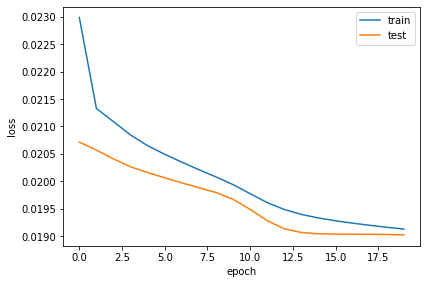

In [ ]:
import matplotlib.pyplot as plt
rcParams['figure.figsize'] =[6.4, 4.4]

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score

# make a prediction
yhat = model_e1d1.predict(test_X)

In [ ]:
test_y2 = test_y.reshape((len(test_y), 4))
test_y2.shape

(8308, 4)

In [ ]:
inv_y = np.concatenate((test_X.reshape((len(test_X), 7)), test_y2), axis=1)
inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
#inv_y[:10]
inv_y[0]

array([6.949200e+01, 7.264000e+00, 1.460771e+04, 2.852000e+02,
       0.000000e+00, 4.000000e+01, 7.100000e+01, 8.317200e+01,
       0.000000e+00, 0.000000e+00, 4.100000e+01])

In [ ]:
yhat_t = yhat.reshape((len(yhat), 4))

inv_yhat = np.concatenate((test_X.reshape((len(test_X), 7)), yhat_t), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat[0]

array([6.94920000e+01, 7.26400000e+00, 1.46077100e+04, 2.85200000e+02,
       0.00000000e+00, 4.00000000e+01, 7.10000000e+01, 9.02127321e+01,
       6.10570963e+01, 7.71938537e+01, 3.40697645e+02])

In [ ]:
from sklearn.metrics import mean_absolute_error

n=2
actual =test_y2[:, n]
actual

pred =yhat_t[:, n]
#pred

# calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.069
Test MAE: 0.025


In [ ]:
from sklearn.metrics import mean_absolute_error
# [7,10]
n=10
actual =inv_y[:, n]
actual

pred =inv_yhat[:, n]
#pred

# calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 318.224
Test MAE: 238.275


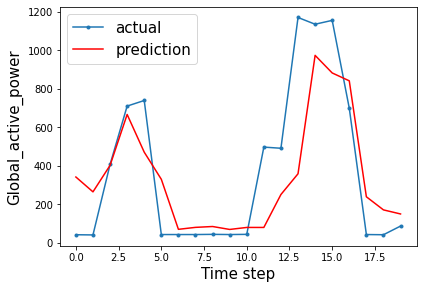

In [ ]:
n=10
aa=[x for x in range(20)]
plt.plot( inv_y[:20, n], marker='.', label="actual")
plt.plot(inv_yhat[:20, n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
inv_yhat_df = pd.DataFrame(inv_yhat[:500], columns=["var1(t-1)","var2(t-1)","var3(t-1)","var4(t-1)","var5(t-1)"	,"var6(t-1)","var7(t-1)","var1(t)",	"var5(t)","var6(t)","var7(t)"])
inv_yhat_df['Dates'] =pd.DatetimeIndex(reframed1[n_train_time:n_train_time+500].copy().reset_index().dt)

inv_yhat_df['day_name'] = df_resample[n_train_time:n_train_time+500].copy().reset_index().day_name
inv_yhat_df.head(2)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var5(t),var6(t),var7(t),Dates,day_name
0,69.492,7.264,14607.71,285.2,0.0,40.0,71.0,90.212732,61.057096,77.193854,340.697645,2009-12-15 18:00:00,Tuesday
1,83.172,6.766,14700.45,340.8,0.0,0.0,41.0,94.129191,55.305922,35.797784,263.651960,2009-12-15 19:00:00,Tuesday


In [ ]:
inv_y_df = pd.DataFrame(inv_y[:500], columns=["var1(t-1)","var2(t-1)","var3(t-1)","var4(t-1)","var5(t-1)"	,"var6(t-1)","var7(t-1)","var1(t)",	"var5(t)","var6(t)","var7(t)"])
inv_y_df['Dates'] = pd.DatetimeIndex(reframed1[n_train_time:n_train_time+500].copy().reset_index().dt)

inv_y_df['day_name'] = df_resample[n_train_time:n_train_time+500].copy().reset_index().day_name
inv_y_df.head(2)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var5(t),var6(t),var7(t),Dates,day_name
0,69.492,7.264,14607.71,285.2,0.0,40.0,71.0,83.172,0.0,0.0,41.0,2009-12-15 18:00:00,Tuesday
1,83.172,6.766,14700.45,340.8,0.0,0.0,41.0,101.642,0.0,0.0,40.0,2009-12-15 19:00:00,Tuesday


In [ ]:
def fun(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Global_active_power.mean()

inv_yhat_df['Gap_hour_avg']=inv_y_df[['Dates', 'day_name']].apply(fun,  axis=1)
inv_yhat_df.head()

In [ ]:
def fun_sum1(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Sub_metering_1.mean() 
def fun_sum2(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Sub_metering_2.mean() 
def fun_sum3(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Sub_metering_3.mean() 


inv_yhat_df['sm1_hour_avg']=inv_y_df[['Dates', 'day_name']].apply(fun_sum1,  axis=1)
inv_yhat_df['sm2_hour_avg']=inv_y_df[['Dates', 'day_name']].apply(fun_sum2,  axis=1)
inv_yhat_df['sm3_hour_avg']=inv_y_df[['Dates', 'day_name']].apply(fun_sum3,  axis=1)
inv_yhat_df.head(2)

167


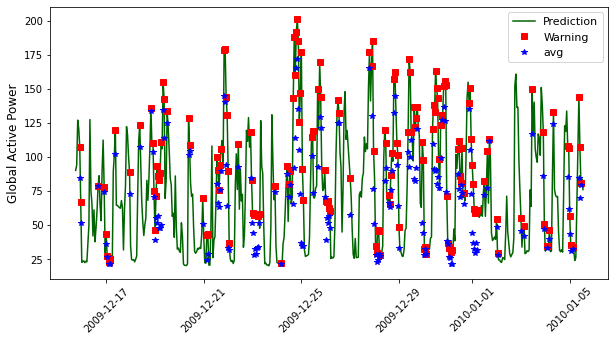

4244.4484073260155

In [ ]:
#Gap_hour_avg
warning_Gap_hour_avg = inv_yhat_df[inv_yhat_df['var1(t)']>inv_yhat_df['Gap_hour_avg']].copy()
warning_Gap_hour_avg['difference']= warning_Gap_hour_avg["var1(t)"] - warning_Gap_hour_avg.Gap_hour_avg
print(warning_Gap_hour_avg.Gap_hour_avg.count())


from pylab import rcParams
rcParams['figure.figsize'] =10, 5

plt.plot(inv_yhat_df.Dates, inv_yhat_df['var1(t)'], color='darkgreen', label="Prediction")
plt.plot(warning_Gap_hour_avg.Dates, warning_Gap_hour_avg["var1(t)"],'s',color='red', label="Warning")
plt.plot(warning_Gap_hour_avg.Dates, warning_Gap_hour_avg.Gap_hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)

plt.ylabel('Global Active Power', size=12)
plt.legend(fontsize=11)

plt.show()


warning_Gap_hour_avg.difference.sum()

163


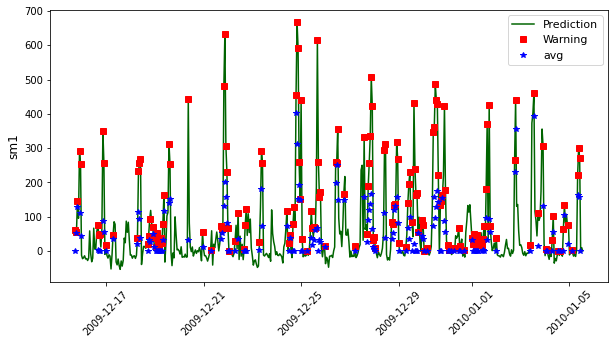

16446.738436285494

In [ ]:
#sm1_hour_avg
warning_sm1_hour_avg = inv_yhat_df[inv_yhat_df['var5(t)']>inv_yhat_df['sm1_hour_avg']].copy()
warning_sm1_hour_avg['difference']= warning_sm1_hour_avg["var5(t)"] - warning_sm1_hour_avg.sm1_hour_avg
print(warning_sm1_hour_avg.sm1_hour_avg.count())


from pylab import rcParams
rcParams['figure.figsize'] =10, 5

plt.plot(inv_yhat_df.Dates, inv_yhat_df['var5(t)'], color='darkgreen', label="Prediction")
plt.plot(warning_sm1_hour_avg.Dates, warning_sm1_hour_avg["var5(t)"],'s',color='red', label="Warning")
plt.plot(warning_sm1_hour_avg.Dates, warning_sm1_hour_avg.sm1_hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)

plt.ylabel('sm1', size=12)
plt.legend(fontsize=11)

plt.show()


warning_sm1_hour_avg.difference.sum()

247


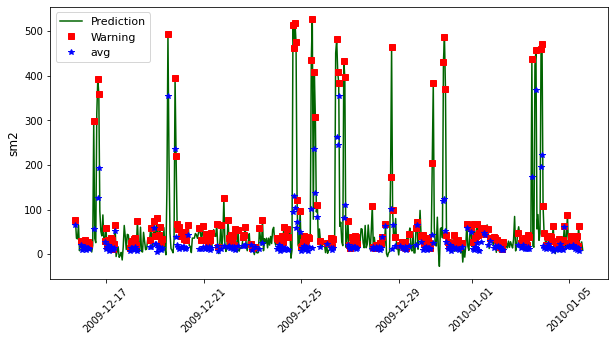

12589.500035570025

In [ ]:
#sm2_hour_avg
warning_sm2_hour_avg = inv_yhat_df[inv_yhat_df['var6(t)']>inv_yhat_df['sm2_hour_avg']].copy()
warning_sm2_hour_avg['difference']= warning_sm2_hour_avg["var6(t)"] - warning_sm2_hour_avg.sm2_hour_avg
print(warning_sm2_hour_avg.sm2_hour_avg.count())


from pylab import rcParams
rcParams['figure.figsize'] =10, 5

plt.plot(inv_yhat_df.Dates, inv_yhat_df['var6(t)'], color='darkgreen', label="Prediction")
plt.plot(warning_sm2_hour_avg.Dates, warning_sm2_hour_avg["var6(t)"],'s',color='red', label="Warning")
plt.plot(warning_sm2_hour_avg.Dates, warning_sm2_hour_avg.sm2_hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)

plt.ylabel('sm2', size=12)
plt.legend(fontsize=11)

plt.show()


warning_sm2_hour_avg.difference.sum()

247


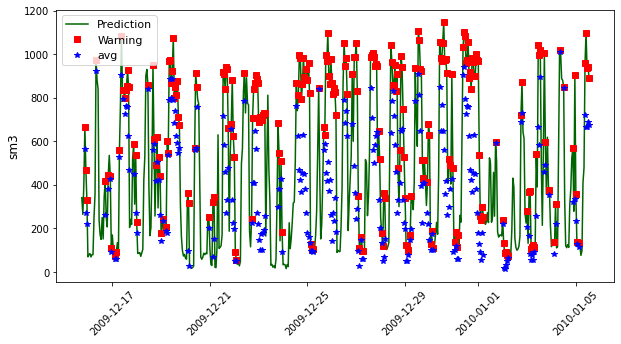

63780.94731462578

In [ ]:
#sm3_hour_avg
warning_sm3_hour_avg = inv_yhat_df[inv_yhat_df['var7(t)']>inv_yhat_df['sm3_hour_avg']].copy()
warning_sm3_hour_avg['difference']= warning_sm3_hour_avg["var7(t)"] - warning_sm3_hour_avg.sm3_hour_avg
print(warning_sm3_hour_avg.sm3_hour_avg.count())


from pylab import rcParams
rcParams['figure.figsize'] =10, 5

plt.plot(inv_yhat_df.Dates, inv_yhat_df['var7(t)'], color='darkgreen', label="Prediction")
plt.plot(warning_sm3_hour_avg.Dates, warning_sm3_hour_avg["var7(t)"],'s',color='red', label="Warning")
plt.plot(warning_sm3_hour_avg.Dates, warning_sm3_hour_avg.sm3_hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)

plt.ylabel('sm3', size=12)
plt.legend(fontsize=11)

plt.show()


warning_sm3_hour_avg.difference.sum()